In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from decimal import Decimal
import datetime as dt
from clv_the_look.preprocess.data import *
from clv_the_look.training.model import *
import pickle
import os
import glob

In [4]:
ord_items_df = pd.read_csv('/Users/Ian/code/wjdals210/raw_data/order_items.csv')
ord_df = pd.read_csv('/Users/Ian/code/wjdals210/raw_data/orders.csv')
users_df = pd.read_csv('/Users/Ian/code/wjdals210/raw_data/users.csv')

In [5]:
clean_df = data_cleaning(ord_items_df,ord_df)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125226 entries, 1 to 125226
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   sale_price  125226 non-null  float64       
 1   user_id     125226 non-null  int64         
 2   created_at  125226 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 3.8 MB


The **recency** variable is a measure of the time elapsed since the customer’s last purchase.

The **frequency** corresponds to the number of orders placed by a customer.

The **monetary** metric shows the total revenue generated by each customer.

Tenure, or **T**, represents how long a given customer has been with the company.

In [6]:
print(clean_df.created_at.min())
print(clean_df.created_at.max())

2019-01-06 05:30:00
2024-01-17 19:46:14.316147


In [7]:
# def train_test_separation(clean_df):

# time_diff = clean_df.created_at.max() - clean_df.created_at.min()  # work out how many days range in the dataset
# train_test_ratio = 0.05  # choose the fraction to use as test

train_start = pd.to_datetime('2019-01-01')
train_end = pd.to_datetime('2020-12-31')
test_end = pd.to_datetime('2021-03-31')

# get the subset of the data, restricted by train period plus test period
clean_df_subset = clean_df[(clean_df.created_at>=train_start) & (clean_df.created_at<=test_end)]

# use the calibration_and_holdout_data method in lifetimes package to separate the time series data    
separated_df = calibration_and_holdout_data(transactions=clean_df_subset, 
                                            customer_id_col="user_id",
                                            datetime_col = "created_at",
                                            monetary_value_col= 'sale_price',
                                            calibration_period_end=train_end,
                                            observation_period_end=test_end)

# return separated_df

In [8]:
separated_df

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
user_id,,,,,,,
9,0.0,0.0,222.0,0.000000,0.0,0.0,90.0
17,2.0,502.0,565.0,287.014994,0.0,0.0,90.0
29,0.0,0.0,287.0,0.000000,0.0,0.0,90.0
46,0.0,0.0,148.0,0.000000,0.0,0.0,90.0
60,0.0,0.0,250.0,0.000000,0.0,0.0,90.0
...,...,...,...,...,...,...,...
99952,0.0,0.0,219.0,0.000000,0.0,0.0,90.0
99976,0.0,0.0,567.0,0.000000,0.0,0.0,90.0
99990,0.0,0.0,123.0,0.000000,0.0,0.0,90.0


In [14]:
clean_df[clean_df.user_id==3].to_csv('testing_csv_input.csv')

___

In [19]:
bg_model = train_bg_model(separated_df)

✅ ß-Geo Model trained


In [20]:
# Predicting the number of purchases in the next 90 days for all customers
separated_df['predicted_purchases'] = bg_model.conditional_expected_number_of_purchases_up_to_time(90,
                                                                                                separated_df['frequency_cal'],
                                                                                                separated_df['recency_cal'],
                                                                                                separated_df['T_cal']
                                                                                               )

In [21]:
rfm_df_filtered = separated_df[separated_df.monetary_value_cal>0]
gg_model = train_gg_model(rfm_df_filtered)

✅ γγ Model trained


In [22]:
separated_df['CLV'] = gg_model.customer_lifetime_value(bg_model,
                                                      separated_df['frequency_cal'],
                                                      separated_df['recency_cal'],
                                                      separated_df['T_cal'],
                                                      separated_df['monetary_value_cal'],
                                                      time = 3,# In months
                                                     )

In [23]:
separated_df['sq_error'] = (separated_df.monetary_value_holdout - separated_df.CLV)**2
print("Root mean square error: "+str(np.sqrt(separated_df['sq_error'].mean())))
separated_df

Root mean square error: 31.335894942831462


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,predicted_purchases,CLV,sq_error
user_id,,,,,,,,,,
9,0.0,0.0,222.0,0.000000,0.0,0.0,90.0,0.049663,4.438276,19.698294
17,2.0,502.0,565.0,287.014994,0.0,0.0,90.0,0.129924,28.615995,818.875171
29,0.0,0.0,287.0,0.000000,0.0,0.0,90.0,0.046744,4.177376,17.450467
46,0.0,0.0,148.0,0.000000,0.0,0.0,90.0,0.053465,4.778046,22.829726
60,0.0,0.0,250.0,0.000000,0.0,0.0,90.0,0.048362,4.321994,18.679636
...,...,...,...,...,...,...,...,...,...,...
99952,0.0,0.0,219.0,0.000000,0.0,0.0,90.0,0.049807,4.451107,19.812356
99976,0.0,0.0,567.0,0.000000,0.0,0.0,90.0,0.037302,3.333426,11.111727
99990,0.0,0.0,123.0,0.000000,0.0,0.0,90.0,0.054884,4.904913,24.058174


In [54]:
# Get the latest model version name by the timestamp on disk
local_model_directory =  os.path.join(os.path.expanduser('~'), "code", "wjdals210", "clv-the-look", "clv_the_look",)
local_model_directory = os.path.join(LOCAL_REGISTRY_PATH, "training")
local_model_paths = glob.glob(f"{local_model_directory}/*")
most_recent_model_path_on_disk = sorted(local_model_paths)[-1]

In [56]:
local_model_paths[-1]

'/Users/Ian/code/wjdals210/clv-the-look/clv_the_look/training/gg_train_model.pkl'

In [46]:
pwd

'/Users/Ian/code/wjdals210/clv-the-look/notebooks'

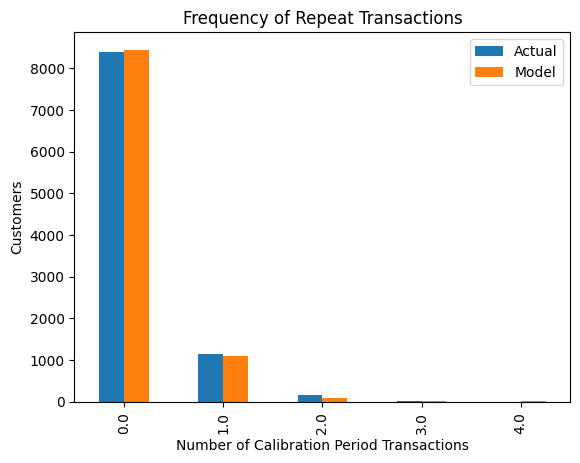

In [24]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bg_model);

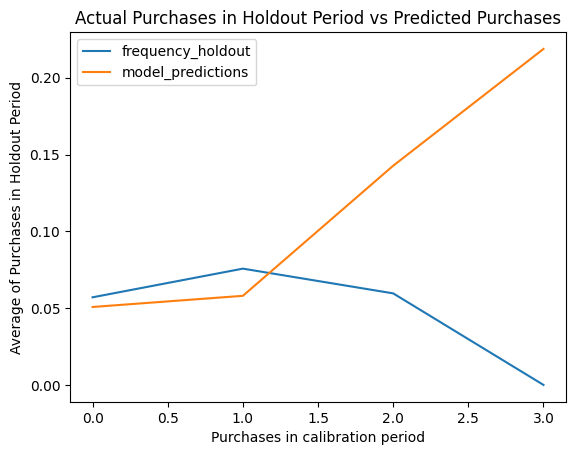

In [25]:
plot_calibration_purchases_vs_holdout_purchases(bg_model,separated_df);

In [57]:
clean_df.columns

Index(['sale_price', 'user_id', 'created_at'], dtype='object')

In [26]:
new_user = pd.DataFrame(columns=clean_df.columns)
new_user.loc[0] = {'sale_price':45,'user_id':'X','created_at':'2020-08-30 08:26:00'}
new_user.loc[1] = {'sale_price':70,'user_id':'X','created_at':'2020-09-07 08:26:00'}
new_user

,sale_price,user_id,created_at
0,45,X,2020-08-30 08:26:00
1,70,X,2020-09-07 08:26:00


In [27]:
new_user_rfm = rfm(new_user)
gg_model.customer_lifetime_value(bg_model,
                                 new_user_rfm['frequency'],
                                 new_user_rfm['recency'],
                                 new_user_rfm['T'],
                                 new_user_rfm['monetary_value'],
                                 time = 3,# In months
                                )

user_id
X    7.077257
Name: clv, dtype: float64

___

### Need to do model tuning